In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from io import StringIO
from mst_clustering import MSTClustering
warnings.filterwarnings('ignore')

In [3]:
#paremeter selection

k = 3
m = 300


In [4]:
#generating points
random_state = 42
points, y = make_blobs(n_samples=m,centers = k, random_state=random_state)



C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\moler\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\moler\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are 

Text(0.5, 1.0, 'K means solution')

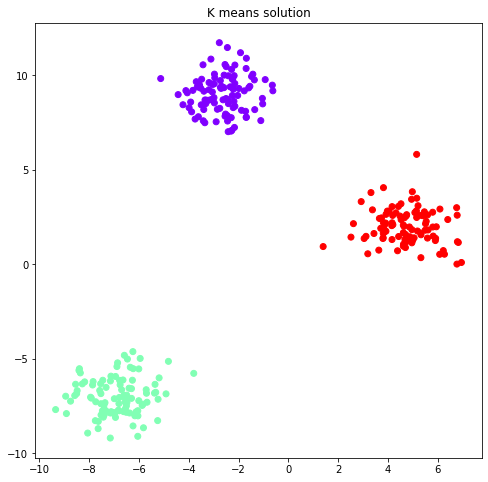

In [5]:
#Kmeans solution
random_state = 170
y_pred = KMeans(n_clusters=k, random_state=random_state).fit_predict(points)


#print clusters
plt.figure(figsize=(8, 8))


plt.scatter(points[:, 0], points[:, 1], c=y_pred,cmap='rainbow')
plt.title("K means solution")

Text(0.5, 1.0, 'MST solution')

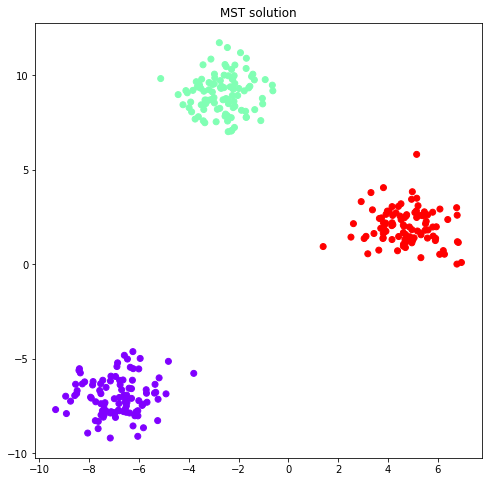

In [9]:
#MST solution
model = MSTClustering(cutoff=k-1)
y_pred_mst = model.fit_predict(points)

#print clusters
plt.figure(figsize=(8, 8))

plt.scatter(points[:, 0], points[:, 1], c=y_pred_mst, cmap='rainbow');
plt.title("MST solution")

In [8]:

#generate matrix distance
dist = [[math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) for i in points] for j in points]
#We write the generated data in a .dat AMPL format.
output = open("Kcluster.dat", "w")
output.write('param k:= '+ str(k) + ';')
output.write('\n')
output.write('param m:= '+ str(m) + ';')
output.write('\n')
output.write('param d: ')
for i in range(m):output.write(str(i + 1) + ' ')
output.write(':=')
output.write('\n')
for i in range(m):
    output.write(str(i + 1) + ' ')
    for j in range(m):
        output.write(str(dist[i][j]))
        if(j != m-1):output.write(' ')
    if(i != m-1):output.write('\n')
output.write(';')
output.write('\n')
output.close()


In [ ]:
###AQUI VA LEXECUCIO DEL AMPL DINTRE DEL JUPYTER

Text(0.5, 1.0, 'LP solution')

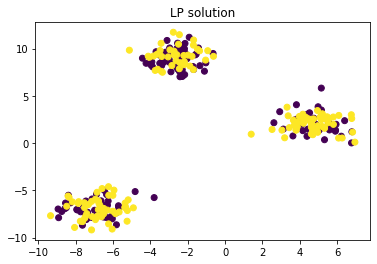

In [8]:
#AMPL solution processing

solution_input = open("solution_matrix.txt", "r")
sol = [0 for _ in range(m)]
clusters = []
for i,line in enumerate(solution_input.readlines()):
    if i > 1 and i < m + 3:
        for j,car in enumerate(line.split()):
            if j > 0 and car == "1":
                if not (j - 1) in clusters: clusters.append(j - 1)
                sol[i - 2] = clusters.index(j - 1)
                
plt.scatter(points[:, 0], points[:, 1], c=sol)
plt.title("LP solution")

In [9]:
#Multidimensional dataset kmeans implementation
df = pd.read_csv('segmentation-data.csv')
kmeans = KMeans(n_clusters=3, init='k-means++', random_state= 42)  
y_predict= kmeans.fit_predict(df)



C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
